## Step 7: Evaluate expression of the epigenetic memory astrocyte gene signature across cell types in the Allen Brain Cell atlas

In recent correspondence with the authors of Lee et al, we learned that the original up- and down- signature gene lists from Supplementary Table 3, Extended Data Figure 3A, and described in the corresponding methods sections were incorrect. The authors stated they applied several fold change and p-value thresholds which were not reported in the original manuscript, but that the corrected signature was in fact used for all the other analyses in the paper. The authors stated that they are in the process of issuing a correction to the original paper to amend Supplementary Table 3, Extended Data Figure 3A, and the methods section. 

Now we'll examine how expression of the corrected epigenetic memory astrocyte signature varies across the cell types in the Allen Brain Cell atlas. 

In [1]:
import os
os.chdir('..') # changing working directory to parent 'EpiMemAstros' directory, adjust as needed
import pandas as pd
from pathlib import Path
import numpy as np
import anndata as ad
from scipy import sparse
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
import seaborn as sns

plt.rcParams['font.family'] = 'Arial'
sc.set_figure_params(dpi = 600, dpi_save = 600, vector_friendly = True, format = 'svg')

First, read in the ABC atlas anndata object we saved in Step 3. Note that this AnnData file is nearly 300 GB in size. Depending on your hardware specifications, you may need to load this file in 'backed' mode so that it is not fully loaded into memory. [See the Scanpy documentation for details.](https://scanpy.readthedocs.io/en/stable/generated/scanpy.read_h5ad.html)

In [2]:
mouse_atlas = sc.read_h5ad('outputs/allen_brain_cell_atlas-RAW.h5ad')
mouse_atlas

AnnData object with n_obs × n_vars = 4042976 × 32285
    obs: 'cell_barcode_x', 'library_label_x', 'anatomical_division_label', 'cell_barcode_y', 'barcoded_cell_sample_label', 'library_label_y', 'feature_matrix_label', 'entity', 'brain_section_label', 'library_method', 'region_of_interest_acronym', 'donor_label', 'donor_genotype', 'donor_sex', 'dataset_label', 'x', 'y', 'cluster_alias', 'abc_sample_id', 'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster'
    var: 'gene_symbol', 'name', 'mapped_ncbi_identifier', 'comment'

This large atlas includes clusters defined at highly granular levels. Because we're interested in expression across general cell type categories, we'll next assign cells into broad cell type categories based on their cluster labels.

We'll first examine the broadest cluster classes present in the dataset.

In [3]:
classes = np.unique(mouse_atlas.obs['class'].values)
classes

array(['01 IT-ET Glut', '02 NP-CT-L6b Glut', '03 OB-CR Glut',
       '04 DG-IMN Glut', '05 OB-IMN GABA', '06 CTX-CGE GABA',
       '07 CTX-MGE GABA', '08 CNU-MGE GABA', '09 CNU-LGE GABA',
       '10 LSX GABA', '11 CNU-HYa GABA', '12 HY GABA', '13 CNU-HYa Glut',
       '14 HY Glut', '15 HY Gnrh1 Glut', '16 HY MM Glut', '17 MH-LH Glut',
       '18 TH Glut', '19 MB Glut', '20 MB GABA', '21 MB Dopa',
       '22 MB-HB Sero', '23 P Glut', '24 MY Glut', '25 Pineal Glut',
       '26 P GABA', '27 MY GABA', '28 CB GABA', '29 CB Glut',
       '30 Astro-Epen', '31 OPC-Oligo', '32 OEC', '33 Vascular',
       '34 Immune'], dtype=object)

Neuron are divided among many different cluster classes, but for our purposes we group them into a single cell type group. Let's extract a list of the neuronal cluster classes.

In [4]:
neuron_prefixes = [f"{i:02d}" for i in range(1, 30)]
neuron_classes = [x for x in classes if x.startswith(tuple(neuron_prefixes))]
neuron_classes

['01 IT-ET Glut',
 '02 NP-CT-L6b Glut',
 '03 OB-CR Glut',
 '04 DG-IMN Glut',
 '05 OB-IMN GABA',
 '06 CTX-CGE GABA',
 '07 CTX-MGE GABA',
 '08 CNU-MGE GABA',
 '09 CNU-LGE GABA',
 '10 LSX GABA',
 '11 CNU-HYa GABA',
 '12 HY GABA',
 '13 CNU-HYa Glut',
 '14 HY Glut',
 '15 HY Gnrh1 Glut',
 '16 HY MM Glut',
 '17 MH-LH Glut',
 '18 TH Glut',
 '19 MB Glut',
 '20 MB GABA',
 '21 MB Dopa',
 '22 MB-HB Sero',
 '23 P Glut',
 '24 MY Glut',
 '25 Pineal Glut',
 '26 P GABA',
 '27 MY GABA',
 '28 CB GABA',
 '29 CB Glut']

Next we create a cell-level metadata dataframe and add a category called 'celltype', grouping cell classes into broad cell type categories. Then, we'll add this category into the anndata object's cell metadata.

In [5]:
obs_df = mouse_atlas.obs

obs_df['celltype'] = np.where(obs_df['class'].isin(neuron_classes), "Neuron", "")
obs_df['celltype'] = np.where(obs_df['subclass']=='316 Bergmann NN', "Bergmann glia", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass'].isin(['317 Astro-CB NN', '318 Astro-NT NN',
       '319 Astro-TE NN', '320 Astro-OLF NN']), "Astrocyte", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='321 Astroependymal NN', "Astroependymal", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='322 Tanycyte NN', "Tanycyte", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='323 Ependymal NN', "Ependymal", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='324 Hypendymal NN', "Hypendymal", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='325 CHOR NN', "Choroid plexus", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='326 OPC NN', "OPC", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='327 Oligo NN', "Oligodendrocyte", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='328 OEC NN', "Olfactory epithelial", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='329 ABC NN', "Arachnoid barrier", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='330 VLMC NN', "Vascular leptomeningeal", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='331 Peri NN', "Pericyte", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='332 SMC NN', "Smooth muscle", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='333 Endo NN', "Endothelial", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='334 Microglia NN', "Microglia", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='335 BAM NN', "BAM", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='336 Monocytes NN', "Monocyte", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='337 DC NN', "Dendritic cell", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='338 Lymphoid NN', "Lymphoid", obs_df['celltype'])

mouse_atlas.obs = obs_df

Let's check the total number of cells present in each broad cell type category.

In [6]:
obs_df.celltype.value_counts()

celltype
Neuron                     2957911
Oligodendrocyte             422574
Astrocyte                   299182
OPC                         122605
Endothelial                  88011
Microglia                    86232
Pericyte                     24907
Smooth muscle                14614
Vascular leptomeningeal       9104
BAM                           5626
Bergmann glia                 3321
Ependymal                     3259
Astroependymal                1232
Olfactory epithelial          1132
Tanycyte                      1072
Arachnoid barrier              857
Choroid plexus                 476
Lymphoid                       404
Dendritic cell                 285
Hypendymal                     139
Monocyte                        33
Name: count, dtype: int64

Because the gene signature lists we have from Lee et al are in gene symbol format, we next swap out gene symbols for the Ensembl IDs previously labeling our anndata object .var slot.

In [7]:
mouse_atlas.var['ensembl_id'] = mouse_atlas.var.index
mouse_atlas.var['gene_symbol'] = mouse_atlas.var['gene_symbol'].astype(str)
mouse_atlas.var['original_gene_symbol'] = mouse_atlas.var.gene_symbol
mouse_atlas.var.index = mouse_atlas.var.gene_symbol
mouse_atlas.var_names_make_unique()

Next, normalize and log-transform the count data.

In [8]:
sc.pp.normalize_total(mouse_atlas, target_sum=10000)
sc.pp.log1p(mouse_atlas)

Now, read in the differential expression data tables provided to us by Lee et al. The authors first extracted genes with |log2FoldChange| > 1.5 and an adjusted p-value < 0.05 in the 2x cytokine challenge condition compared to the 1x cytokine challenge condition. Genes from this list with a log2-fold change > 1.5 which were also significantly elevated in the 2x cytokine condition compared to the 2x PBS control condition (log2-fold change > 1 & adjusted p-value < 0.05) were defined as the epigenetic memory astrocyte 'up-signature'. Genes from this list with a log2-fold change < -1.5 which were also significantly decreased in the 2x cytokine condition compared to the 2x PBS control condition (log2-fold change < -1, adjusted p-value < 0.05) were defined as the epigenetic memory astrocyte 'down-signature'. 

We next create lists containing the respective signatures.

In [9]:
IL1bTNF_2x_vs_1x = pd.read_csv('inputs/zenodo/2x.IL1B.and.TNF.vs.1x.IL1B.dge.tsv', sep = '\t')
IL1bTNF_2x_vs_1x

gene       baseMean  log2FoldChange     lfcSE      stat  \
0      CT010467.1  124446.148700        0.455587  0.362753  1.255914   
1             Ttr   74426.275190        0.897000  0.108443  8.271617   
2         mt-Rnr2   66757.698840       -0.031207  0.121890 -0.256027   
3           Enpp2   29064.492830        0.871519  0.133810  6.513127   
4          Hba-a2   23984.201900        3.825147  1.087431  3.517600   
...           ...            ...             ...       ...       ...   
15018     Ube2cbp       7.728455       -1.238908  0.817726 -1.515065   
15019      Kif18b       7.728034        0.134820  0.862799  0.156259   
15020    Vmn2r112       7.725002        0.476563  0.836310  0.569840   
15021       Mkrn3       7.723282        0.118420  0.796802  0.148619   
15022     Gm47725       7.714739       -0.196477  0.861696 -0.228012   

             pvalue          padj  
0      2.091471e-01  5.446381e-01  
1      1.320000e-16  7.640000e-14  
2      7.979299e-01  9.370387e-01  
3      7.360000e-11  9.790000e-09  
4      4.354690e-04  6.893625e-03  
...             ...           ...  
15018  1.297560e-01  4.247821e-01  
15019  8.758290e-01  9.623037e-01  
15020  5.687865e-01  8.419430e-01  
15021  8.818543e-01  9.645503e-01  
15022  8.196372e-01  9.439156e-01  

[15023 rows x 7 columns]

In [10]:
IL1bTNF_2x_vs_PBS = pd.read_csv('inputs/zenodo/IL1B.and.TNF.vs.PBS.SPF.2X.dge.tsv', sep = '\t')
IL1bTNF_2x_vs_PBS

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0610009B22Rik   78.812410       -0.363154  0.291599 -1.245388  2.129892e-01   
0610009L18Rik   18.443451        0.041385  0.541863  0.076375  9.391207e-01   
0610010F05Rik   42.415183       -0.605503  0.462934 -1.307968  1.908841e-01   
0610010K14Rik   68.455460       -0.249080  0.302570 -0.823216  4.103850e-01   
0610012G03Rik  204.118073       -0.199607  0.229044 -0.871477  3.834939e-01   
...                   ...             ...       ...       ...           ...   
Zxdc            39.831013       -0.405883  0.459556 -0.883208  3.771241e-01   
Zyg11b         190.196661        0.478162  0.302771  1.579285  1.142707e-01   
Zyx            304.579626        1.261724  0.237969  5.302058  1.145044e-07   
Zzef1          171.114679        0.102497  0.212882  0.481474  6.301797e-01   
Zzz3           119.875086        0.179802  0.248478  0.723613  4.693032e-01   

                   padj  
0610009B22Rik  0.501482  
0610009L18Rik  0.981228  
0610010F05Rik  0.471765  
0610010K14Rik  0.704073  
0610012G03Rik  0.684113  
...                 ...  
Zxdc           0.679247  
Zyg11b         0.346355  
Zyx            0.000003  
Zzef1          0.851926  
Zzz3           0.748815  

[15916 rows x 6 columns]

In [11]:
sig_IL1bTNF_2x_vs_1x = IL1bTNF_2x_vs_1x[(abs(IL1bTNF_2x_vs_1x['log2FoldChange']) > 1.5) & (IL1bTNF_2x_vs_1x['padj'] < 0.05)]
sig_IL1bTNF_2x_vs_1x

gene      baseMean  log2FoldChange     lfcSE       stat  \
4       Hba-a2  23984.201900        3.825147  1.087431   3.517600   
7       Hbb-bs  21423.790010        3.874507  1.085827   3.568254   
36      Hba-a1   6929.729412        3.698403  1.034282   3.575818   
59      Hbb-bt   4357.529785        3.685705  1.072986   3.434998   
66      Slc6a1   4085.769821       -1.760055  0.151622 -11.608171   
...        ...           ...             ...       ...        ...   
14318   Gm2606     10.131547        6.707670  1.373494   4.883655   
14341      Vdr     10.045608        2.848188  0.891781   3.193818   
14744  Gm49450      8.624805        6.477571  1.397906   4.633767   
14812   Ms4a4b      8.419461        3.141413  1.058298   2.968362   
14879    Itga2      8.159245       -3.214116  1.117103  -2.877189   

             pvalue          padj  
4      4.354690e-04  6.893625e-03  
7      3.593680e-04  5.861881e-03  
36     3.491340e-04  5.751146e-03  
59     5.925590e-04  8.651127e-03  
66     3.750000e-31  7.030000e-28  
...             ...           ...  
14318  1.040000e-06  4.140000e-05  
14341  1.404045e-03  1.736047e-02  
14744  3.590000e-06  1.190800e-04  
14812  2.993911e-03  3.111850e-02  
14879  4.012355e-03  3.892357e-02  

[231 rows x 7 columns]

In [12]:
up_IL1bTNF_2x_vs_PBS = IL1bTNF_2x_vs_PBS[(IL1bTNF_2x_vs_PBS['log2FoldChange'] > 1) & (IL1bTNF_2x_vs_PBS['padj'] < 0.05)]
up_IL1bTNF_2x_vs_PBS

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
1110038B12Rik   45.336811        1.036884  0.346841  2.989507  2.794276e-03   
1600010M07Rik    8.700279        3.850476  1.124593  3.423885  6.173279e-04   
1700030N03Rik   22.298105        2.532594  0.597480  4.238790  2.247277e-05   
4833407H14Rik    6.018952        5.814355  1.507210  3.857695  1.144612e-04   
4930594M22Rik   10.655680        2.556997  0.858898  2.977069  2.910187e-03   
...                   ...             ...       ...       ...           ...   
Zc3h12a         43.412321        1.138573  0.397591  2.863682  4.187479e-03   
Zfp810          38.095733        1.203947  0.412285  2.920179  3.498309e-03   
Zfp969          10.765285        5.663164  1.576863  3.591413  3.288905e-04   
Zfp984          23.221016        1.392342  0.496394  2.804912  5.033039e-03   
Zyx            304.579626        1.261724  0.237969  5.302058  1.145044e-07   

                   padj  
1110038B12Rik  0.021173  
1600010M07Rik  0.005866  
1700030N03Rik  0.000319  
4833407H14Rik  0.001347  
4930594M22Rik  0.021931  
...                 ...  
Zc3h12a        0.029687  
Zfp810         0.025570  
Zfp969         0.003424  
Zfp984         0.034558  
Zyx            0.000003  

[853 rows x 6 columns]

In [13]:
down_IL1bTNF_2x_vs_PBS = IL1bTNF_2x_vs_PBS[(IL1bTNF_2x_vs_PBS['log2FoldChange'] < -1) & (IL1bTNF_2x_vs_PBS['padj'] < 0.05)]
down_IL1bTNF_2x_vs_PBS

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
1700019D03Rik   35.668994       -1.255101  0.416017 -3.016944  2.553367e-03   
1700112J16Rik   11.292001       -2.823058  0.929762 -3.036325  2.394810e-03   
2310022B05Rik  174.128346       -1.076005  0.199553 -5.392089  6.964307e-08   
2310061I04Rik   78.933356       -1.036116  0.295308 -3.508601  4.504704e-04   
2610035D17Rik  109.822688       -1.011595  0.252246 -4.010353  6.062792e-05   
...                   ...             ...       ...       ...           ...   
Wscd1          926.911684       -1.047272  0.171383 -6.110698  9.919614e-10   
Zfp273          19.712322       -1.512927  0.556545 -2.718426  6.559325e-03   
Zfp354c         58.138907       -1.029143  0.359657 -2.861453  4.217046e-03   
Zranb3          30.028036       -1.499186  0.559635 -2.678863  7.387260e-03   
Zswim5          68.507076       -1.482371  0.302085 -4.907131  9.241816e-07   

                       padj  
1700019D03Rik  1.976624e-02  
1700112J16Rik  1.876701e-02  
2310022B05Rik  1.802340e-06  
2310061I04Rik  4.475460e-03  
2610035D17Rik  7.670540e-04  
...                     ...  
Wscd1          3.654643e-08  
Zfp273         4.266376e-02  
Zfp354c        2.987027e-02  
Zranb3         4.697389e-02  
Zswim5         1.834074e-05  

[579 rows x 6 columns]

In [14]:
up_signature = sig_IL1bTNF_2x_vs_1x[(sig_IL1bTNF_2x_vs_1x['log2FoldChange'] > 1.5) & (sig_IL1bTNF_2x_vs_1x['gene'].isin(up_IL1bTNF_2x_vs_PBS.index.values))].gene.values
print(up_signature)
print(len(up_signature))

['Il1b' 'Ccrl2' 'S100a9' 'Plek' 'Csf3r' 'S100a8' 'Acod1' 'Clec4e' 'Il1r2'
 'Cxcl2' 'Tnfaip3' 'Lilr4b' 'Hcar2' 'Lilrb4a' 'Trem1' 'Lrg1' 'Csf2rb'
 'Pirb' 'Hp' 'Cxcr2' 'Ptafr' 'Plaur' 'Il1rn' 'Wfdc17' 'Nlrp3' 'Cyp4f18'
 'Cd300lf' 'Plbd1' 'Cldn5' 'Themis2' 'Fgr' 'Slfn2' 'Sell' 'Syk' 'Igsf6'
 'Rab11fip1' 'Tlr13' 'Gda' 'Actg2' 'Samsn1' 'Sla' 'Clec4d' 'Arg2' 'Ackr1'
 'Mcemp1' 'Apoc2' 'Atp1a3' 'Orm2' 'Pik3r5' 'Ncf4' 'Il1f9' 'Cd101'
 'Slc15a3' 'Myo1g' 'Mefv' 'Fras1' 'Ankrd33b' 'Trim30b' 'Ms4a4a' 'Asprv1'
 'Lamc2' 'Pmaip1' 'Fli1' 'Ptpre' 'Napsa' 'Clec4n' 'Evi2b' 'Gm5150' 'Acp5'
 'Fpr1' 'Slc28a2' 'Gm14548' 'Tnfsf14' 'Slfn1' 'A830018L16Rik' 'Tlr7' 'Btk'
 'Ccl20' 'Itpr3' 'Cxcl3' 'B430306N03Rik' 'Tnfrsf9' 'Tent5b' 'Pilrb1'
 'Mirt2' 'Tarm1' 'Cd69' 'Treml4' 'Ccdc88b' 'Gm15922' 'Vdr']
91


In [15]:
down_signature = sig_IL1bTNF_2x_vs_1x[(sig_IL1bTNF_2x_vs_1x['log2FoldChange'] < -1.5) & (sig_IL1bTNF_2x_vs_1x['gene'].isin(down_IL1bTNF_2x_vs_PBS.index.values))].gene.values
print(down_signature)
print(len(down_signature))

['Slc6a1' 'Htra1' 'Itih3' 'S1pr1' 'Agt' 'Gm10925' 'Slc7a10' 'Acsl6'
 'Slc6a11' 'Adcyap1r1' 'Myorg' 'Paqr7' 'Tlcd1' 'Cldn10' 'Entpd2' 'Cers1'
 'Etnppl' 'Hsd11b1' 'Hacd2' 'Wnt7b' 'Astn1' 'Kcnn2' 'Dbx2' 'AW047730'
 'Cxcl14' 'Fam181b' 'Hrh1' 'Gabrg1' 'Cyp4f15' 'Cd38' 'Igsf1' 'Hes5'
 'Sfrp5' 'Wnt7a' 'Cdh10' 'Npas3' 'Slitrk2' 'Tmem229a' 'Mir124-2hg' 'Hlf'
 'Kcng4' 'Scrg1' 'Baalc' 'Arpp21' 'Tmem161b' 'Col11a2' 'Ephb3' 'Adcy8'
 'B3galt2' 'Adgrb1' 'Ttpa' 'Dab1' 'Kirrel2' '2900052N01Rik' 'Nat8f5'
 '2810459M11Rik' 'Slc25a34' 'Gm12258' 'Kcnd2' 'Gm266' 'A330076C08Rik'
 'Cideb' 'AI849053' 'Atp7b' 'Naaladl2' 'Asic1' 'Prss35' 'Zfp273' 'Celrr'
 'Cyp26b1' 'Gm3888']
71


Now we run the scanpy function score_genes to calculate an enrichment score for the Up- and Down- signature gene sets for each single cell. This function implements the same scoring method described in [Tirosh et al 2016 (PMID: 27124452)](https://pubmed.ncbi.nlm.nih.gov/27124452/), also used by the [Seurat function AddModuleScore](https://satijalab.org/seurat/reference/addmodulescore), which Lee et al used for scoring their gene signatures in the mouse and human single-cell RNA-seq datasets in Figures 4 & 5. 

In [16]:
sc.tl.score_genes(mouse_atlas, gene_list=up_signature, score_name="Up_Signature")
sc.tl.score_genes(mouse_atlas, gene_list=down_signature, score_name="Down_Signature")

Next, we'll calculate the mean and standard deviation of the Up- and Down- signature enrichment scores within each cell type.

In [17]:
rainbow = ["#E8ECFB", "#D5C9E5", "#BEA0CC", "#A779B4", "#92569E", "#6B4F9E", "#5666B6", "#4D82C5", "#4F97BA",
"#58A3AA", "#64AE97", "#7AB779", "#A0BD57", "#C6B844", "#DDA83B", "#E69036", "#E5702F", "#DE4627",
"#C2221F", "#881F19", "#521A13"]

cell_obs = mouse_atlas.obs

means = cell_obs.groupby('celltype')['Up_Signature'].mean()
stds = cell_obs.groupby('celltype')['Up_Signature'].std()

dmeans = cell_obs.groupby('celltype')['Down_Signature'].mean()
dstds = cell_obs.groupby('celltype')['Down_Signature'].std()

means_df = pd.DataFrame({'up':means, 'down':dmeans, 'upstd':stds, 'downstd':dstds})

means_df['sum'] = means_df.up + -1*means_df.down

means_df = means_df.sort_values(by = 'sum')

means_df['color'] = np.flip(rainbow)

means_df

up      down     upstd   downstd       sum  \
celltype                                                                    
Astrocyte               -0.116027  0.552030  0.015539  0.118036 -0.668057   
Bergmann glia           -0.131583  0.284989  0.012412  0.062848 -0.416571   
Astroependymal          -0.120311  0.236895  0.018021  0.173440 -0.357206   
OPC                     -0.107174  0.163066  0.019082  0.056065 -0.270240   
Tanycyte                -0.131393 -0.015497  0.020082  0.061120 -0.115896   
Neuron                  -0.083221  0.008117  0.025095  0.046134 -0.091338   
Oligodendrocyte         -0.119392 -0.040903  0.017498  0.041212 -0.078490   
Olfactory epithelial    -0.086826 -0.011210  0.022737  0.058280 -0.075616   
Ependymal               -0.122699 -0.091845  0.021992  0.050822 -0.030855   
Vascular leptomeningeal -0.123410 -0.105606  0.023238  0.049087 -0.017804   
Choroid plexus          -0.107353 -0.116149  0.014543  0.030642  0.008796   
Hypendymal              -0.122917 -0.136150  0.021050  0.037373  0.013234   
Pericyte                -0.104602 -0.123921  0.022773  0.046527  0.019319   
Arachnoid barrier       -0.131958 -0.155753  0.020324  0.036573  0.023794   
Smooth muscle           -0.101840 -0.152031  0.019418  0.040298  0.050191   
Endothelial             -0.047984 -0.128584  0.027893  0.048422  0.080600   
Lymphoid                 0.004962 -0.107063  0.043755  0.044591  0.112025   
BAM                      0.046065 -0.147826  0.044896  0.039737  0.193890   
Microglia                0.073553 -0.136932  0.050451  0.039191  0.210485   
Dendritic cell           0.220989 -0.158601  0.102981  0.033617  0.379591   
Monocyte                 0.706712 -0.105072  0.324739  0.039916  0.811785   

                           color  
celltype                          
Astrocyte                #521A13  
Bergmann glia            #881F19  
Astroependymal           #C2221F  
OPC                      #DE4627  
Tanycyte                 #E5702F  
Neuron                   #E69036  
Oligodendrocyte          #DDA83B  
Olfactory epithelial     #C6B844  
Ependymal                #A0BD57  
Vascular leptomeningeal  #7AB779  
Choroid plexus           #64AE97  
Hypendymal               #58A3AA  
Pericyte                 #4F97BA  
Arachnoid barrier        #4D82C5  
Smooth muscle            #5666B6  
Endothelial              #6B4F9E  
Lymphoid                 #92569E  
BAM                      #A779B4  
Microglia                #BEA0CC  
Dendritic cell           #D5C9E5  
Monocyte                 #E8ECFB

Plot those values in a scatter plot: 

/var/folders/s3/tntkzwtx595cbz0665j_z4tc0000gr/T/ipykernel_56099/1640134074.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(x=means_df['down'][idxs[0]], y=means_df['up'][idxs[0]], label = cluster, s = 70, edgecolor='black', linewidth=0.5, color = color)
/var/folders/s3/tntkzwtx595cbz0665j_z4tc0000gr/T/ipykernel_56099/1640134074.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.errorbar(x=means_df['down'][idxs[0]], y=means_df['up'][idxs[0]], xerr=means_df['downstd'][idxs[0]], yerr=means_df['upstd'][idxs[0]], color=color, alpha = 0.7)


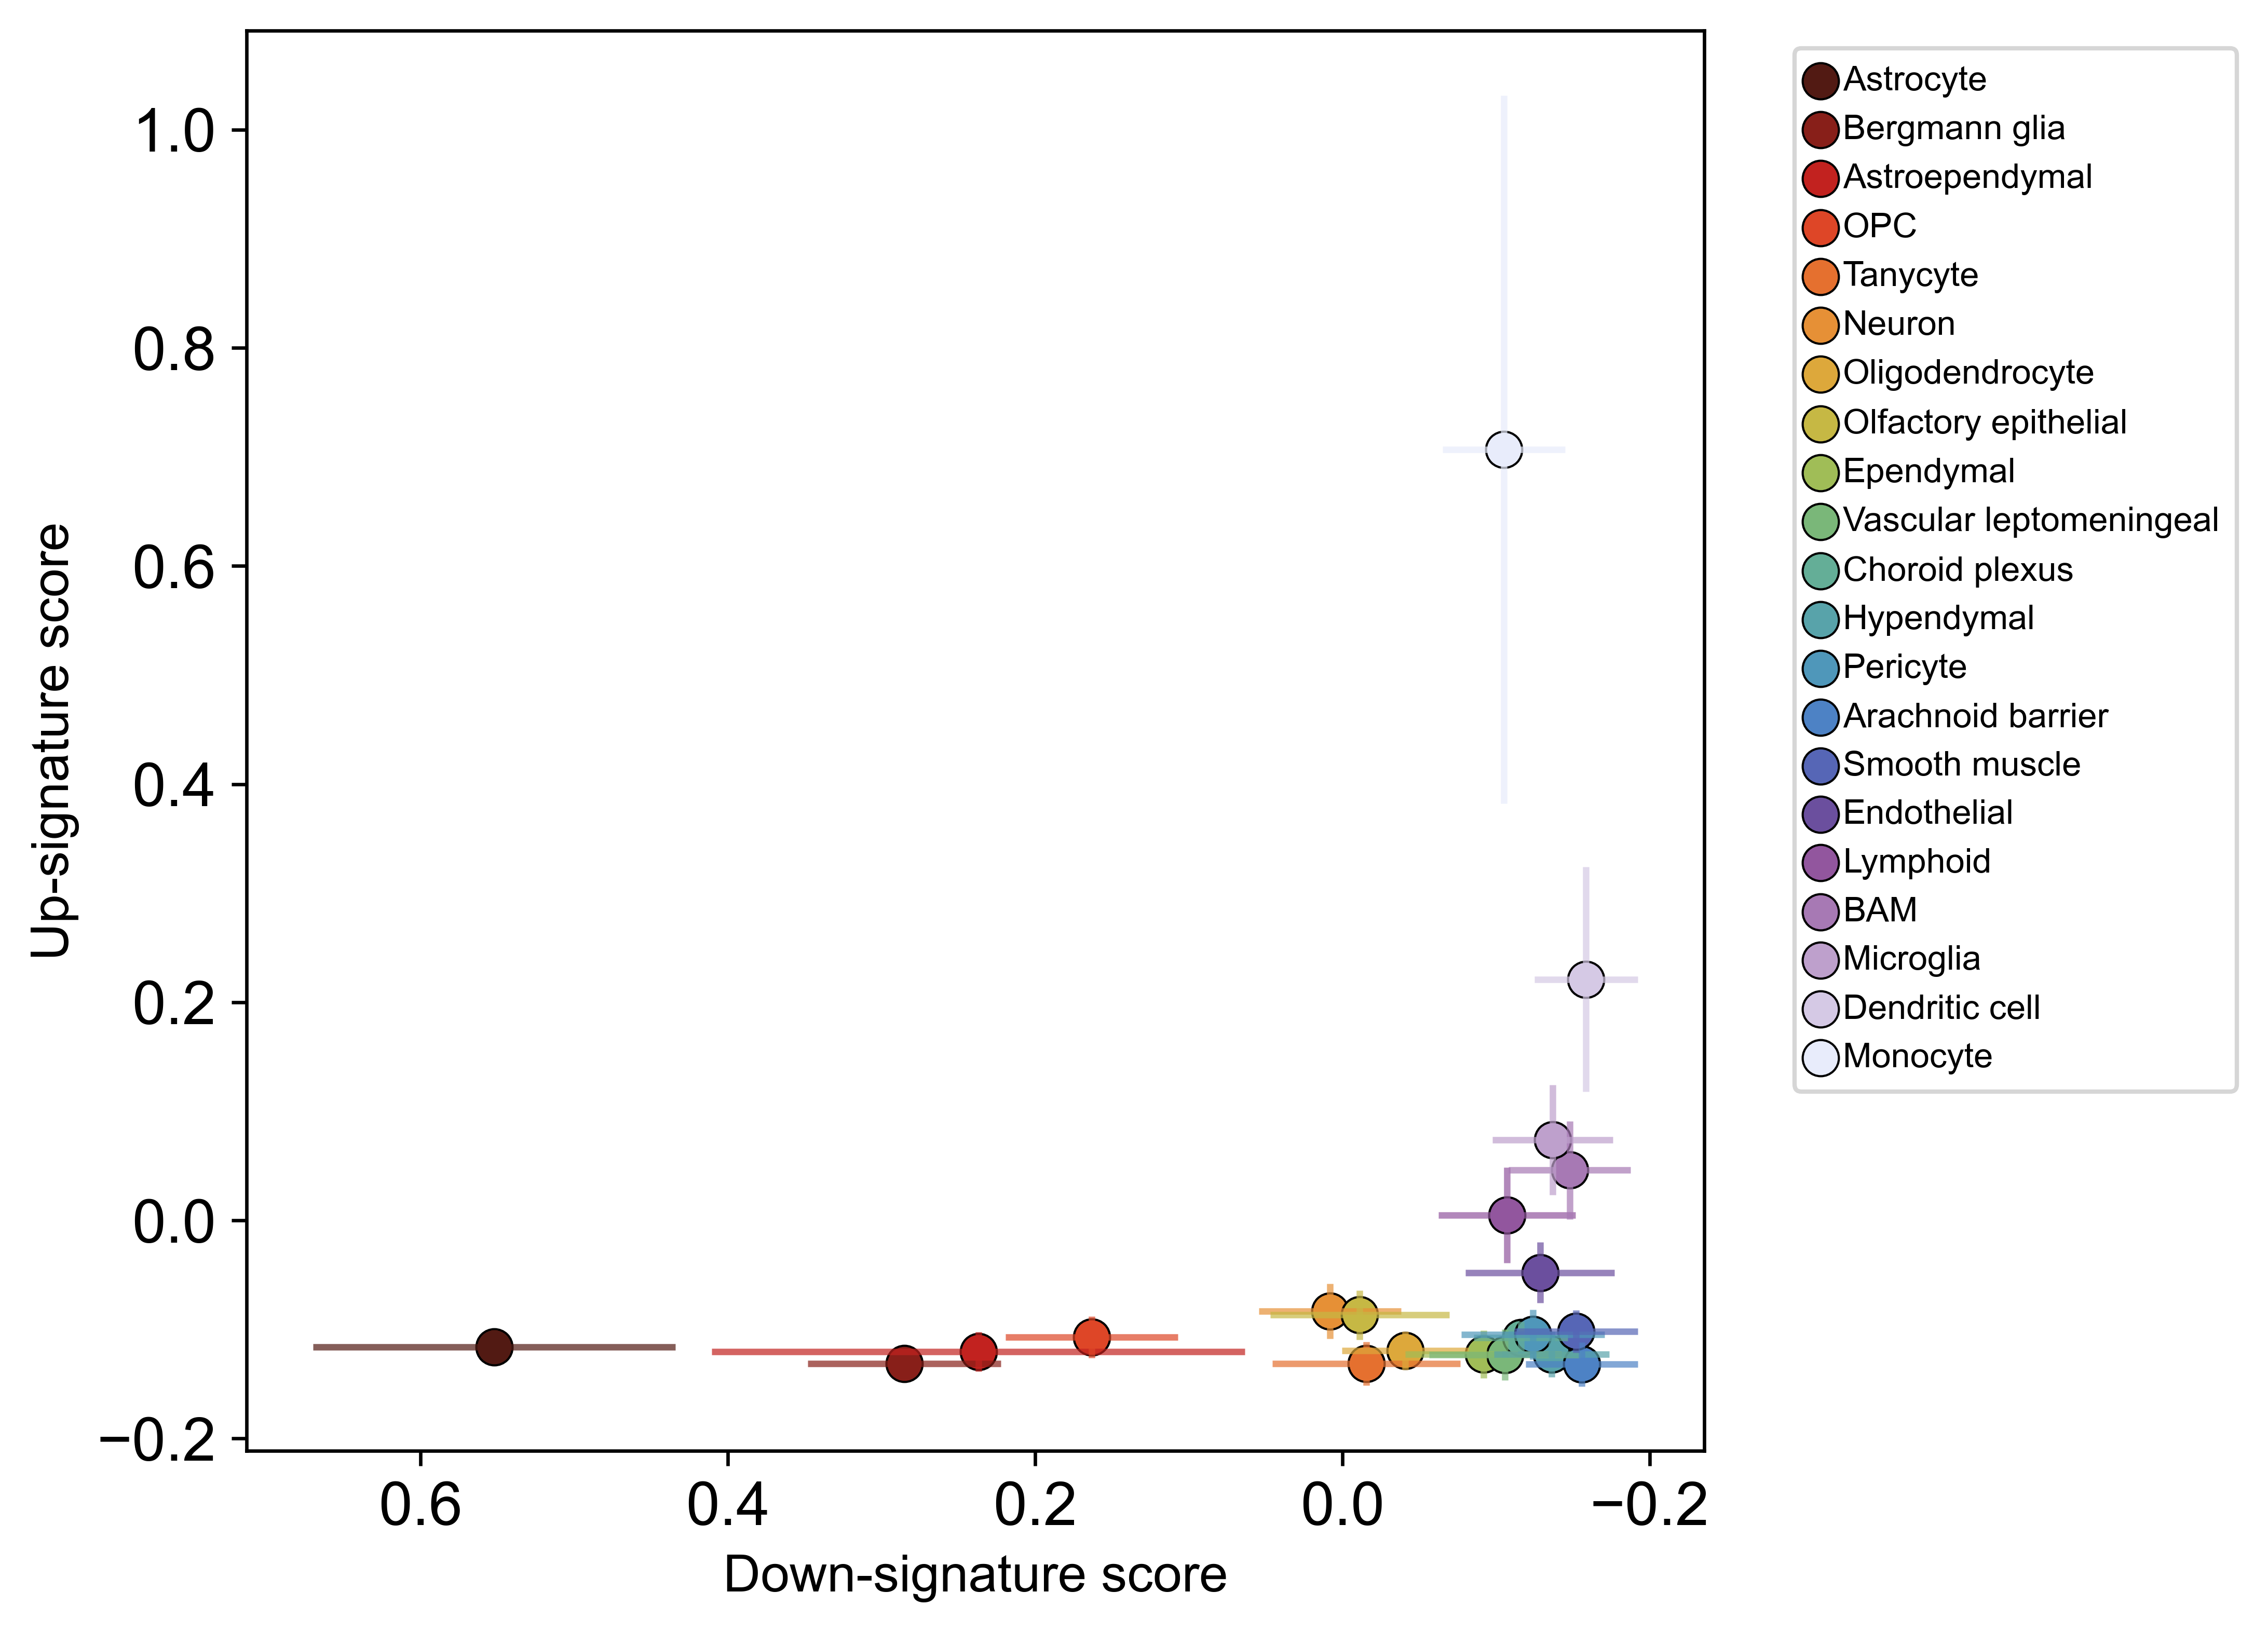

In [18]:
with plt.rc_context({"figure.figsize": (6, 6), "figure.dpi":300}):
    fig, ax = plt.subplots()
    for cluster, color in zip(means_df.index.values, means_df['color'].values):
        idxs = np.where(means_df.index.values == cluster)
        ax.scatter(x=means_df['down'][idxs[0]], y=means_df['up'][idxs[0]], label = cluster, s = 70, edgecolor='black', linewidth=0.5, color = color)
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=8, markerscale=1, borderpad=0.5)
    
    for cluster, color in zip(means_df.index.values, means_df['color'].values):
        idxs = np.where(means_df.index.values == cluster)
        plt.errorbar(x=means_df['down'][idxs[0]], y=means_df['up'][idxs[0]], xerr=means_df['downstd'][idxs[0]], yerr=means_df['upstd'][idxs[0]], color=color, alpha = 0.7)

    ax.invert_xaxis()
    plt.grid(False)
    plt.xlabel('Down-signature score', fontsize=12)
    plt.ylabel('Up-signature score', fontsize=12)
    
    plt.savefig('outputs/figures/figure1d_combination_plot.svg', format='svg', bbox_inches = 'tight')

Create a matching color palette for violin plots:

In [19]:
color_pal = dict(zip(means_df.index.values, means_df.color))

Now we evalute the distribution of enrichment scores across the cell type groups.

First for the Up-Signature: 

/Users/liddelowlab/mambaforge/envs/EpiMemAstros/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:928: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


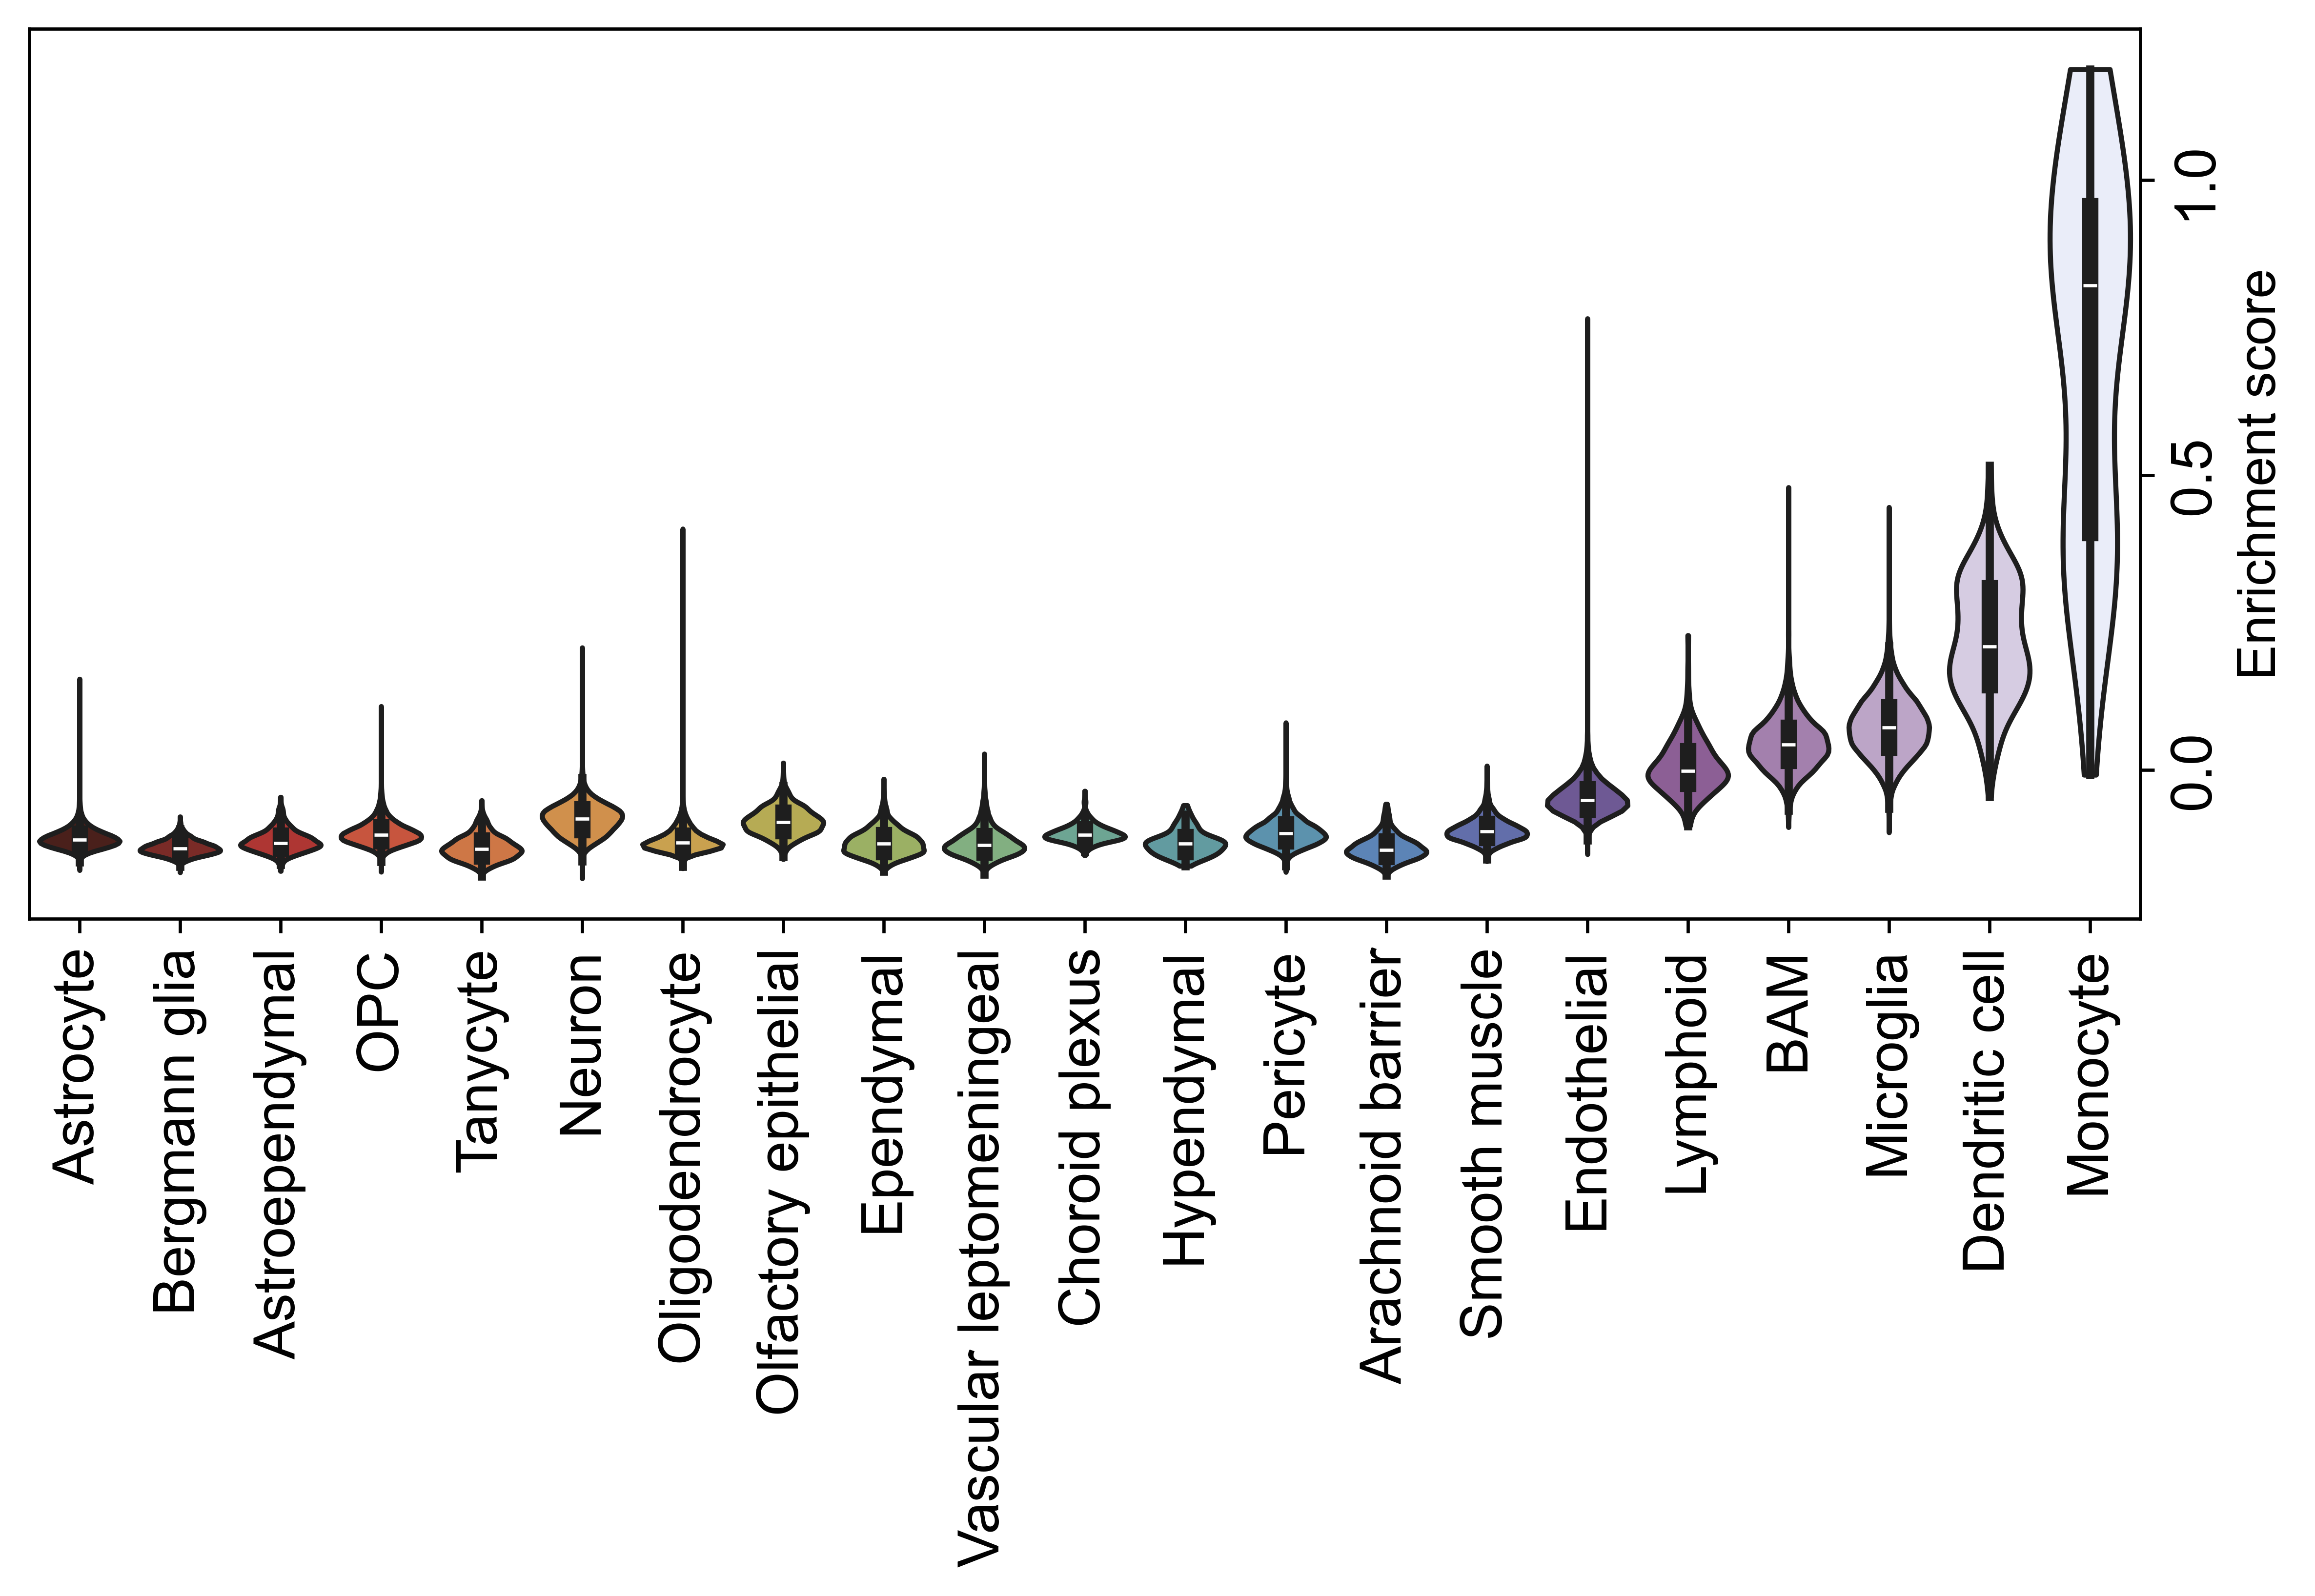

In [20]:
with plt.rc_context({"figure.figsize": (8, 4), "figure.dpi":300}):
    ax = sc.pl.violin(mouse_atlas, keys=['Up_Signature'], groupby="celltype", rotation=90, stripplot = False, inner = 'box', 
                order = means_df.index.values,
                palette = color_pal, show=False, inner_kws=dict(box_width=4, whis_width=2))
    plt.ylabel('Enrichment score', fontsize = 13)
    plt.grid(False)
    ax.yaxis.set_label_position('right')
    ax.yaxis.tick_right()
    plt.yticks(rotation = 90, va='center')
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    plt.savefig('outputs/figures/figure1d_upsignature.svg', format='svg', bbox_inches = 'tight')

And for the Down-Signature:

/Users/liddelowlab/mambaforge/envs/EpiMemAstros/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:928: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


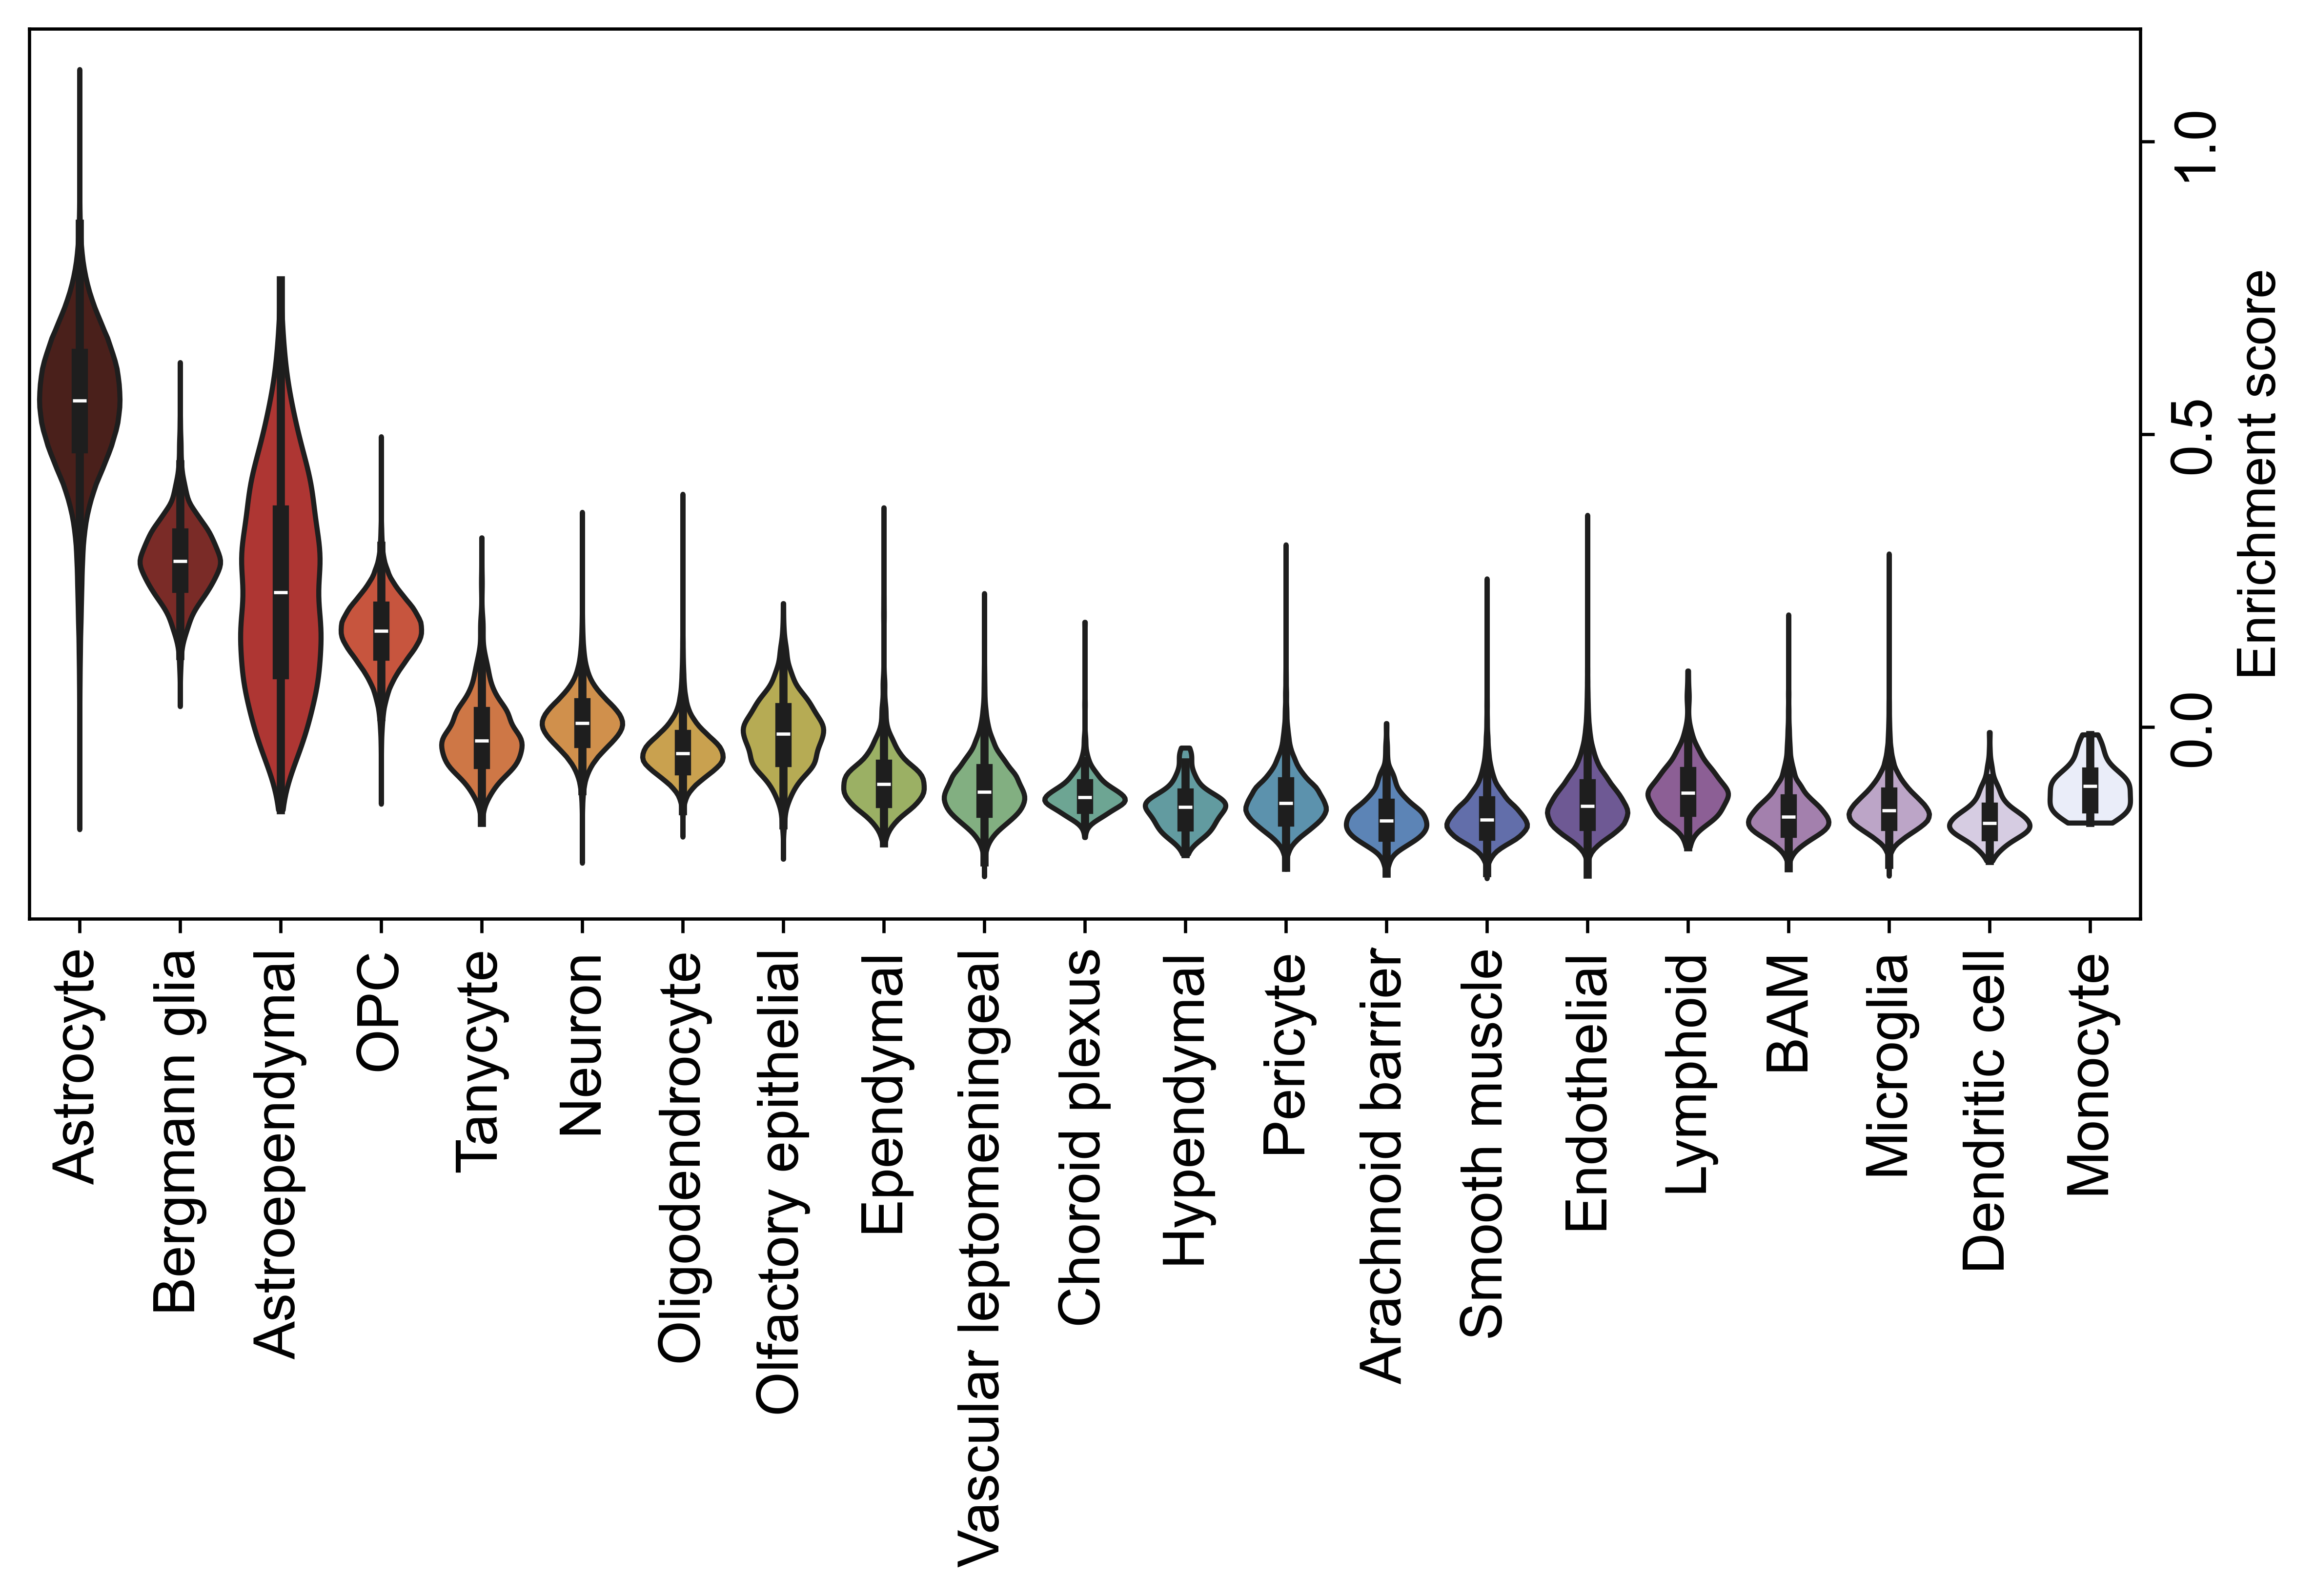

In [21]:
with plt.rc_context({"figure.figsize": (8, 4), "figure.dpi":300}):
    ax = sc.pl.violin(mouse_atlas, keys=['Down_Signature'], groupby="celltype", rotation=90, stripplot = False, inner = 'box',
               order = means_df.index.values,
                palette = color_pal, show=False, inner_kws=dict(box_width=4, whis_width=2))
    plt.ylabel('Enrichment score', fontsize = 13)
    plt.grid(False)
    ax.yaxis.set_label_position('right')
    ax.yaxis.tick_right()
    plt.yticks(rotation = 90, va='center')
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    plt.savefig('outputs/figures/figure1d_downsignature.svg', format='svg', bbox_inches = 'tight')

Next, we'll evaluate the FIND-seq derived gene signature from Supplementary Table 9 in the same manner.

In [22]:
findseq = pd.read_excel('inputs/zenodo/supplementary_tables/41586_2024_7187_MOESM10_ESM.xlsx', header=None)
findseq = findseq[0].values
sc.tl.score_genes(mouse_atlas, gene_list=findseq, score_name="FINDseq_Signature")

       'Gm19220', 'Gm19327', 'Gm25190', 'Gm25197', 'Gm25735', 'Gm28017',
       'Gm37033', 'Gm37144', 'Gm37376', 'Gm38043', 'Gm38152', 'Gm38302',
       'Gm42535', 'Gm43321', 'Gm43540', 'Gm43652', 'Gm45223', 'Gm45799',
       'Gm47164', 'Gm47542', 'Gm47673', 'Gm48204', 'Gm48216', 'Gm48269',
       'Gm48271', 'Gm48309', 'Gm48600', 'Gm6899', 'Gm7968', 'mt-Rnr1',
       'mt-Rnr2', 'Rpl15-ps3', 'Rpl31-ps8', 'Rpl37rt', 'Rps12-ps3',
       'Rps23-ps1', 'Septin11', 'Ubb-ps'],
      dtype='object')


In [23]:
cell_obs = mouse_atlas.obs
means = cell_obs.groupby('celltype')['FINDseq_Signature'].mean()
findseq_order = means.sort_values().index.values

/var/folders/s3/tntkzwtx595cbz0665j_z4tc0000gr/T/ipykernel_56099/3497314576.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = cell_obs.groupby('celltype')['FINDseq_Signature'].mean()


/Users/liddelowlab/mambaforge/envs/EpiMemAstros/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:928: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


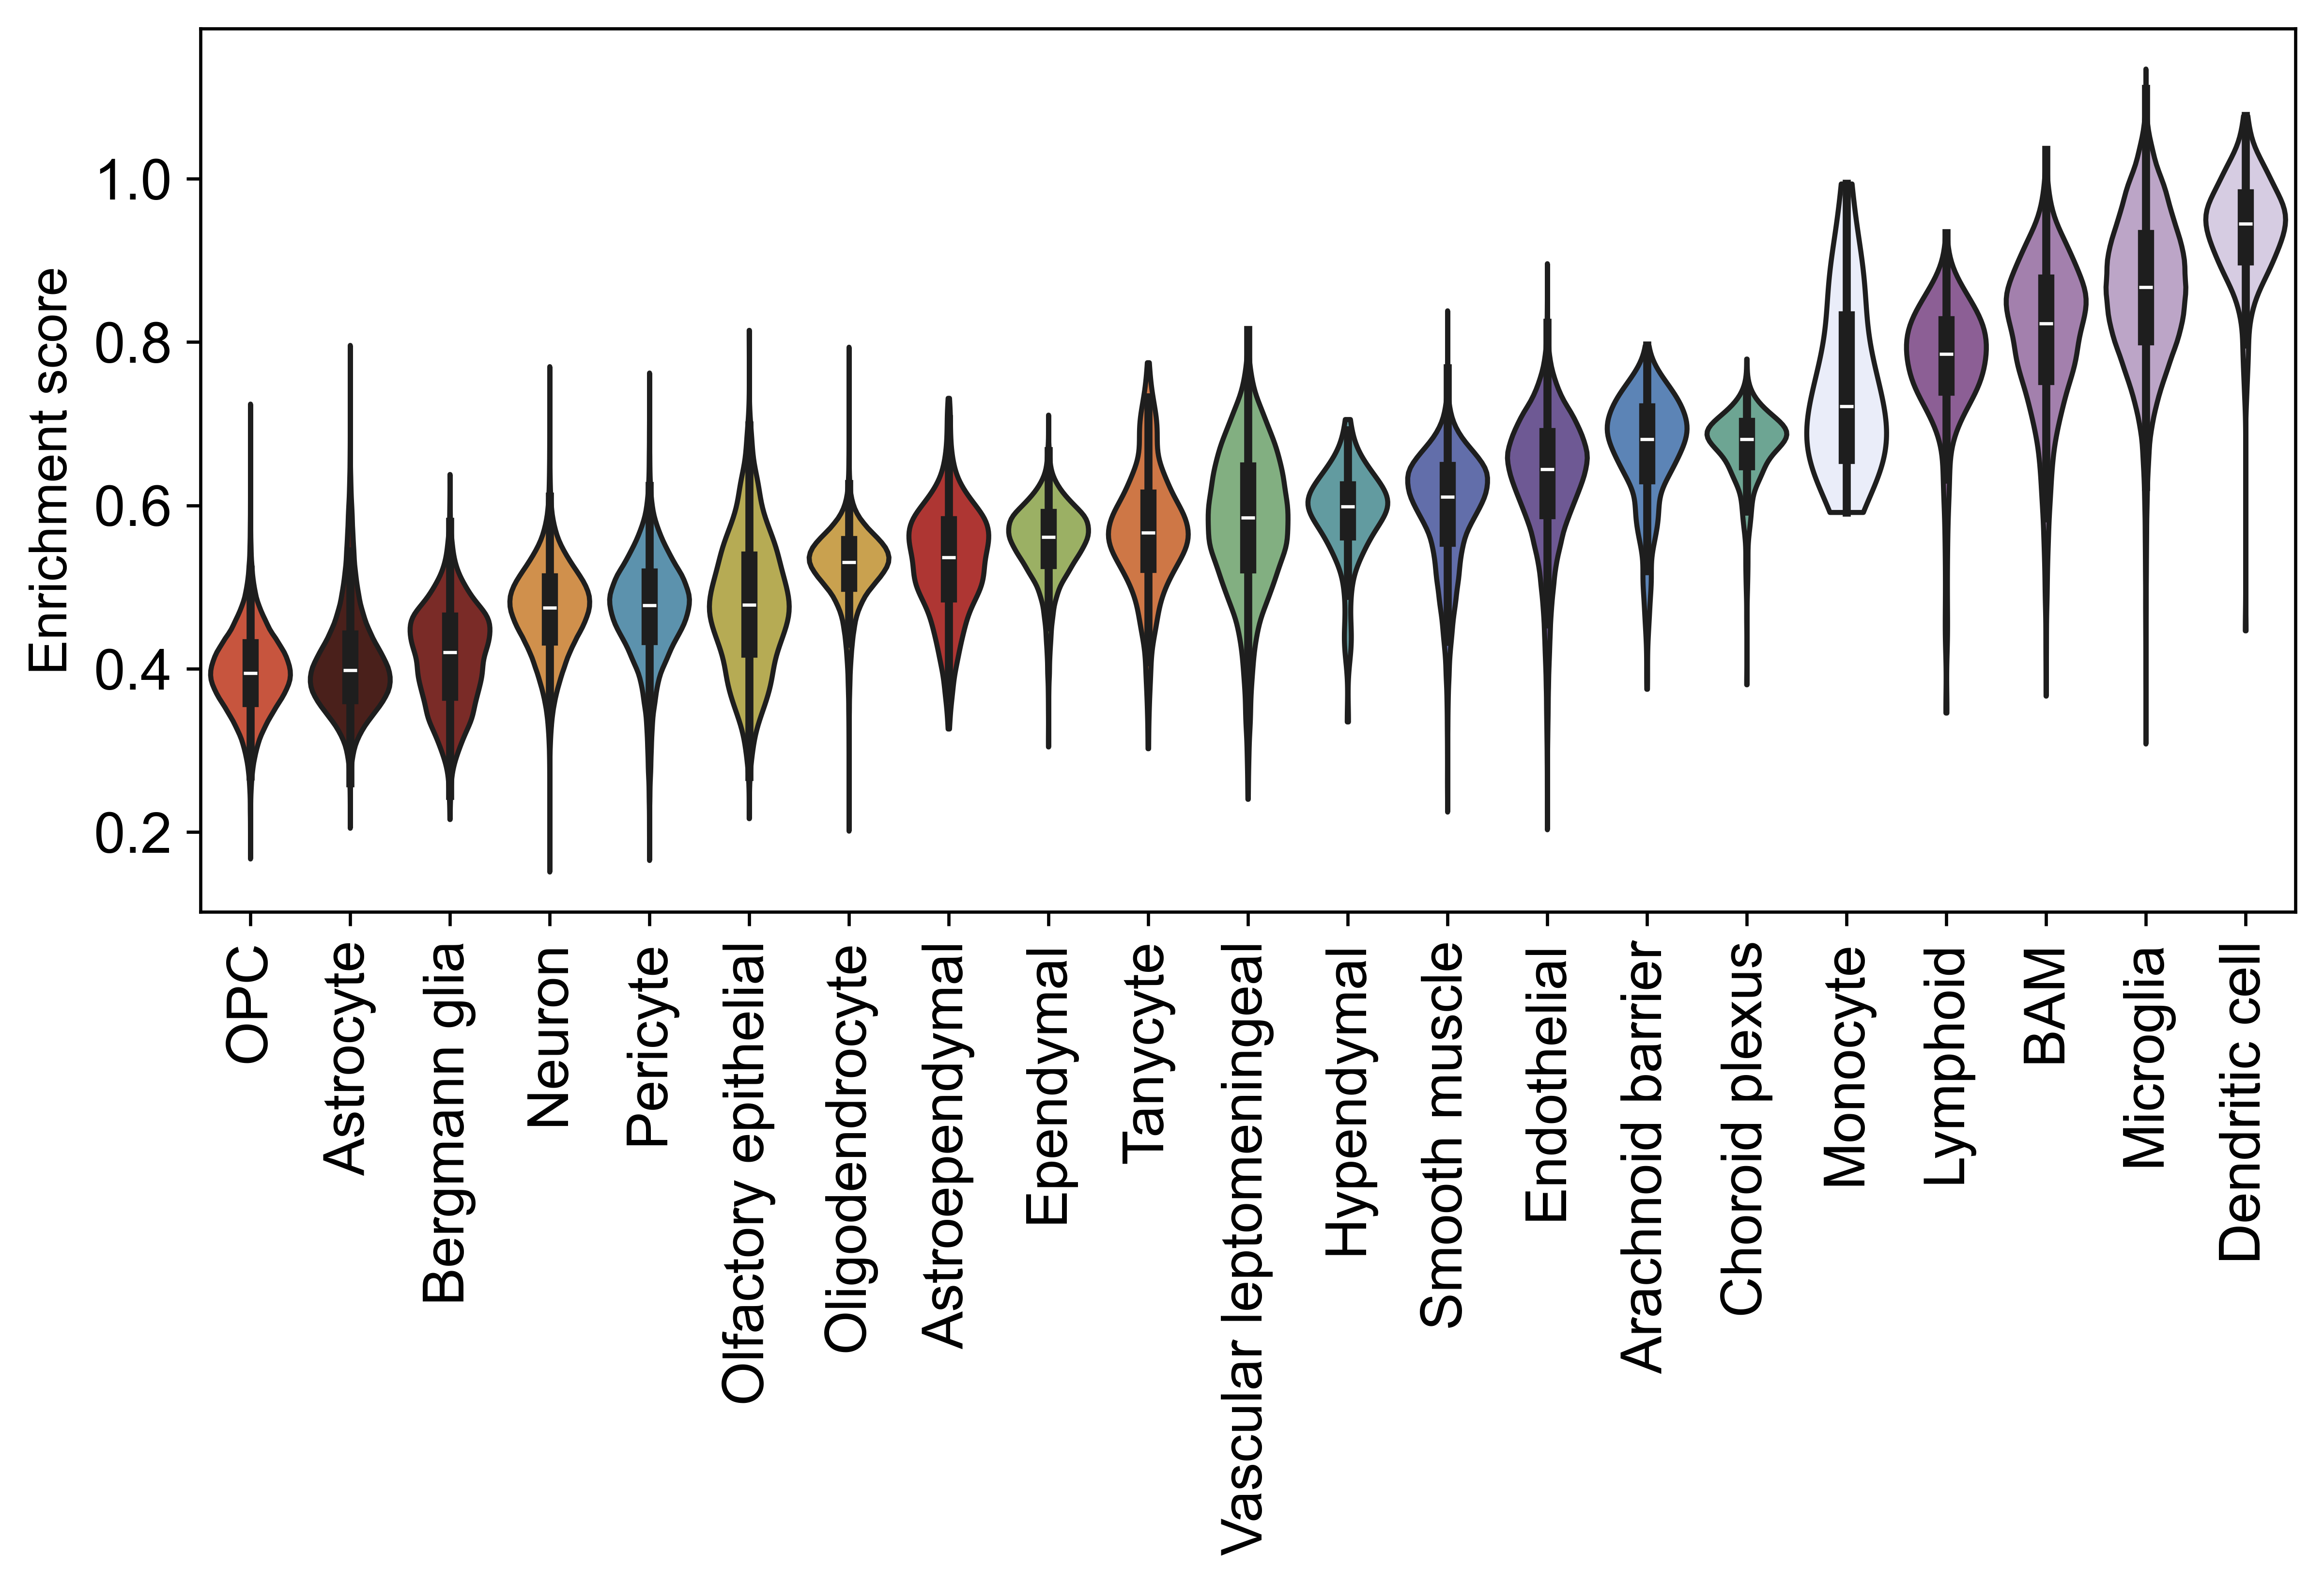

In [24]:
with plt.rc_context({"figure.figsize": (8, 4), "figure.dpi":300}):
    ax = sc.pl.violin(mouse_atlas, keys=['FINDseq_Signature'], groupby="celltype", rotation=90, stripplot = False, inner = 'box', 
                order = findseq_order,
                palette = color_pal, show=False, inner_kws=dict(box_width=4, whis_width=2))
    plt.ylabel('Enrichment score', fontsize = 13)
    plt.grid(False)
    plt.savefig('outputs/figures/extendeddatafigure1a.svg', format='svg', bbox_inches = 'tight')

Now, we'll extract matrices containing the average normalized expression within each cell type class for the up-signature genes and down-signature genes, and save these as CSV files. We'll use these for plotting heatmaps in Step 8.

In [25]:
avg_ad = sc.get.aggregate(mouse_atlas, by = "celltype", func="mean")
avg_exp = pd.DataFrame(avg_ad.layers['mean'].T, index = avg_ad.var_names, columns = avg_ad.obs_names)

up_signature_avg_exp = avg_exp[avg_exp.index.isin(up_signature)]
up_signature_avg_exp.to_csv("outputs/mouse_atlas_corrected_up_signature_avg_expression_dataframe.csv")

down_signature_avg_exp = avg_exp[avg_exp.index.isin(down_signature)]
down_signature_avg_exp.to_csv("outputs/mouse_atlas_corrected_down_signature_avg_expression_dataframe.csv")

Lastly, we'll evaluate expression of Ep300 and Acly across all the cell type groups.

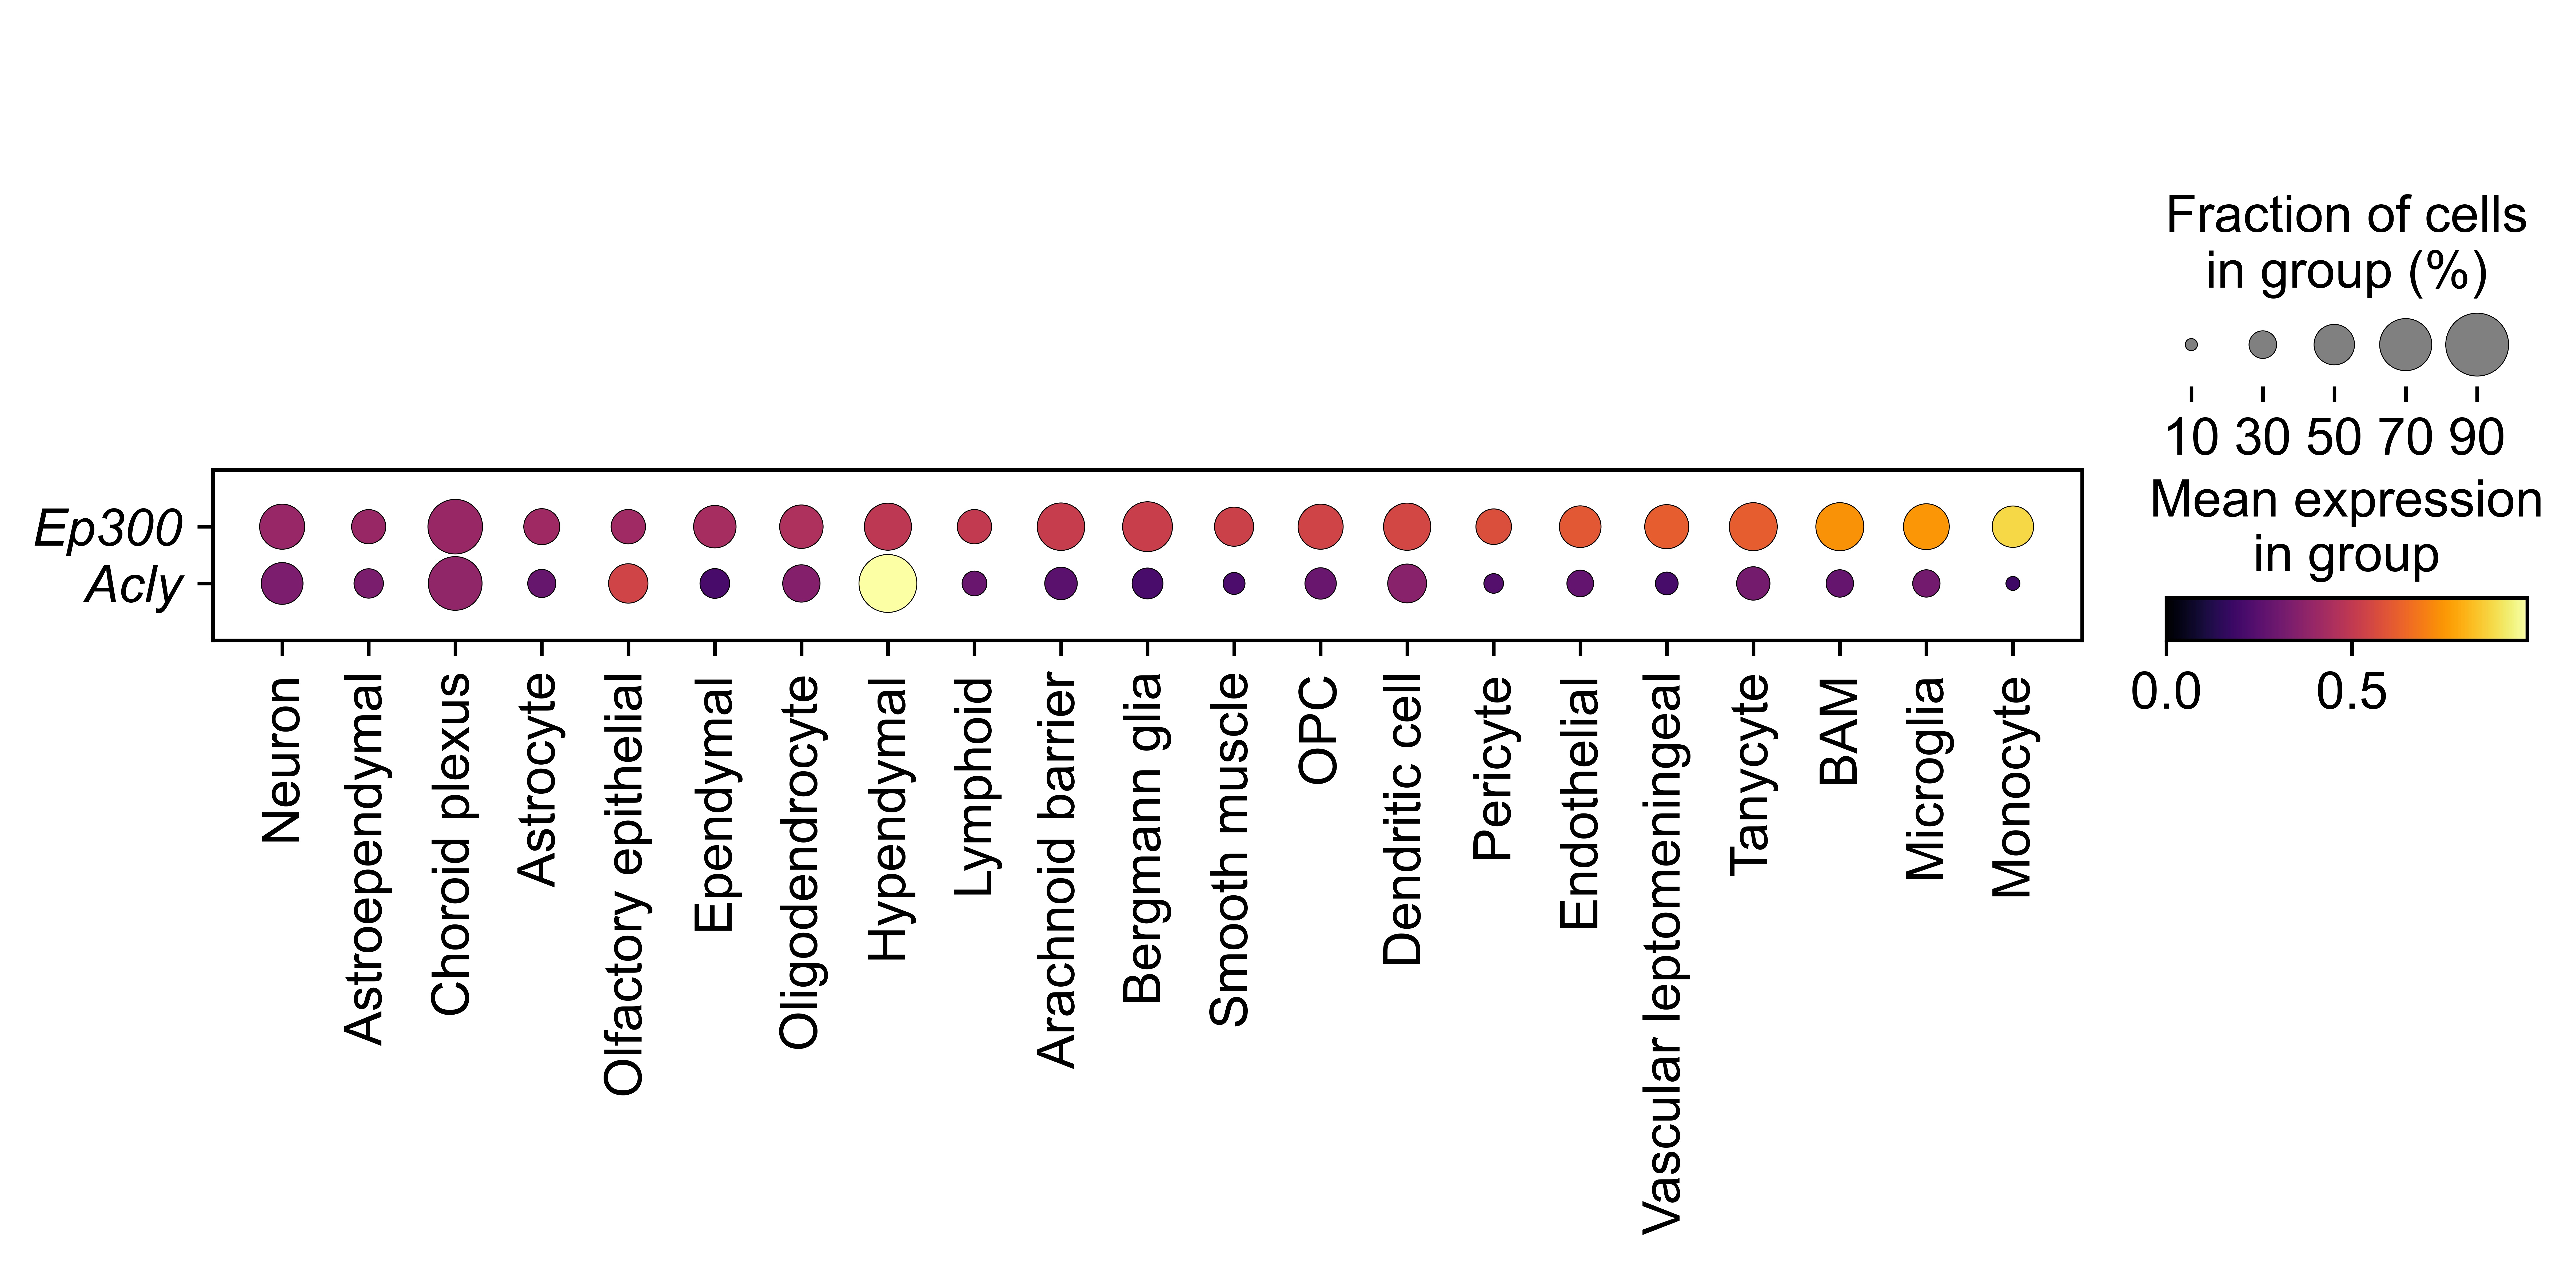

In [26]:
with plt.rc_context({"figure.figsize": (8, 4), "figure.dpi":600}):
    cat_order = avg_exp[avg_exp.index == 'Ep300'].transpose().sort_values(by = "Ep300").index.values
    
    dp = sc.pl.dotplot(mouse_atlas, var_names=['Ep300', 'Acly'], groupby="celltype", swap_axes = True, vmin = 0, cmap = "inferno",
             categories_order = cat_order, show = False)

    ax = dp['mainplot_ax']
    for l in ax.get_yticklabels():
        l.set_style('italic')
    
    fig = plt.gcf()
    cbar_ax = fig.axes[-1]
    cbar_ax.grid(False)
    
    plt.savefig('outputs/figures/figure1g.svg', format='svg', bbox_inches = 'tight')
    plt.show()